In this file, we amplitude encode nouns represented by four dimensional vectors in classical vector spaces onto Hilbert spaces spanned by two qubits. 

We use three different models for the QNLP workflow:
    - Numpy model 
    - Tket model 
    - Pennylane model 

And we use different methods of amplitude encoding:
    - Encoding of Wikipedia2Vec 
    - Encoding of Naive assumption 

In [1]:
# Import all kinds of lambeq stuff 
from lambeq.backend.grammar import (Box, Cap, Cup, Diagram, Diagrammable,
                                    Functor, grammar, Id, Spider, Swap,
                                    Ty, Word)
from lambeq.backend.drawing import draw
import matplotlib.pyplot as plt
import matplotlib
from lambeq import AtomicType

# optimising the diagram to make the resulting quanutm circuit less complex
from lambeq import RemoveSwapsRewriter, RemoveCupsRewriter
from lambeq import Rewriter 

# creating the quantum circuit
from lambeq import IQPAnsatz
from pytket.extensions.qiskit import tk_to_qiskit

import numpy as np

# amplitude Encoding
from qiskit import QuantumCircuit

/home/bob/anaconda3/envs/code/lib/python3.9/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
import numpy as np

BATCH_SIZE = 10
EPOCHS = 500
LEARNING_RATE = 3e-2
SEED = 2

In [3]:

# load training data 

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, forget  = read_data('../datasets/mc_train_data.txt')
test_labels, forget = read_data('../datasets/mc_test_data.txt')
val_labels, forget = read_data('../datasets/mc_dev_data.txt')


# here, we can choose between either the original dataset by Coecke et al. or the new one for Gijs' data

gijs = True

if not gijs: 
    # new way, maybe the things after the words confused lambeq in creating the diagrams 
    with open('../datasets/newTestSentences.txt', 'r') as file: 
        test_data = file.readlines()
    with open('../datasets/newTrainSentences.txt', 'r') as file: 
        train_data = file.readlines()
    with open('../datasets/newValSentences.txt', 'r') as file: 
        val_data = file.readlines()

    test_data = [sentence.strip() for sentence in test_data]
    train_data = [sentence.strip() for sentence in train_data]
    val_data = [sentence.strip() for sentence in val_data]


if gijs:
    # new way, maybe the things after the words confused lambeq in creating the diagrams 
    with open('../datasets/testGijs.txt', 'r') as file: 
        test_data = file.readlines()
    with open('../datasets/trainGijs.txt', 'r') as file: 
        train_data = file.readlines()
    with open('../datasets/valGijs.txt', 'r') as file: 
        val_data = file.readlines()

    test_data = [sentence.strip() for sentence in test_data]
    train_data = [sentence.strip() for sentence in train_data]
    val_data = [sentence.strip() for sentence in val_data]


In [4]:
# parse sentences from data to diagrams 

from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


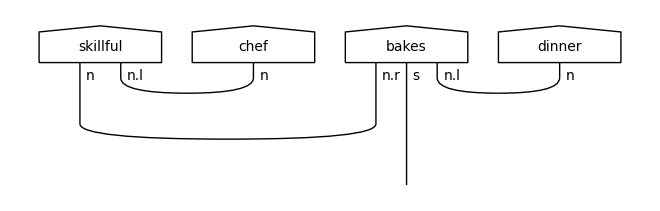

In [5]:
raw_train_diagrams[1].draw()

In [6]:
# normalising by removing cups 

from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_val_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]



In [7]:
'''
This is new when amplitude encoding: 

we include the dictionary indicating what four dimensional word vector to use for what word 

'''

import json

# wiki2vec
with open("../datasets/newNounVectorsPCA.json", 'r') as fp:
    parameterDict = json.load(fp)

# extreme encodes all words to two extreme sides of the bloch sphere 
# with open("../datasets/extremeNounVectors.json", 'r') as fp:
#     parameterDict = json.load(fp)

# trivial encodes all words to [0,0,0,0]
# with open("../datasets/trivialNounVectors.json", 'r') as fp:
#     parameterDict = json.load(fp)
#

# NQ = 2

# # in the case of one qubit, the parameter dict is simply: 
# if NQ == 1:
#     parameterDict = {}
#     parameterDict['woman'] = np.pi/2
#     parameterDict['man'] = np.pi/2
#     parameterDict['person'] = np.pi/2
#     parameterDict['meal'] = 0
#     parameterDict['dinner'] = 0
#     parameterDict['sauce'] = 0
#     parameterDict['program'] = np.pi
#     parameterDict['application'] = np.pi
#     parameterDict['software'] = np.pi



The number of noun parameters does not fit the number of single qubit operators. 
we choose the paramter 0 for the symbol:  chef__n_0
we choose the paramter 0 for the symbol:  sauce†_n__0
we choose the paramter 0 for the symbol:  dinner†_n__0
we choose the paramter 0 for the symbol:  meal__n_0
we choose the paramter 0 for the symbol:  chef†_n__0
we choose the paramter 0 for the symbol:  meal†_n__0
we choose the paramter pi for the symbol:  programmer__n_0
we choose the paramter pi for the symbol:  program†_n__0
we choose the paramter pi/2 for the symbol:  person†_n__0
we choose the paramter pi for the symbol:  application__n_0
we choose the paramter pi/2 for the symbol:  person__n_0
we choose the paramter pi for the symbol:  programmer†_n__0
we choose the paramter pi for the symbol:  application†_n__0
we choose the paramter pi for the symbol:  software†_n__0
we choose the paramter 0 for the symbol:  dinner__n_0
we choose the paramter pi for the symbol:  program__n_0
we choose the param

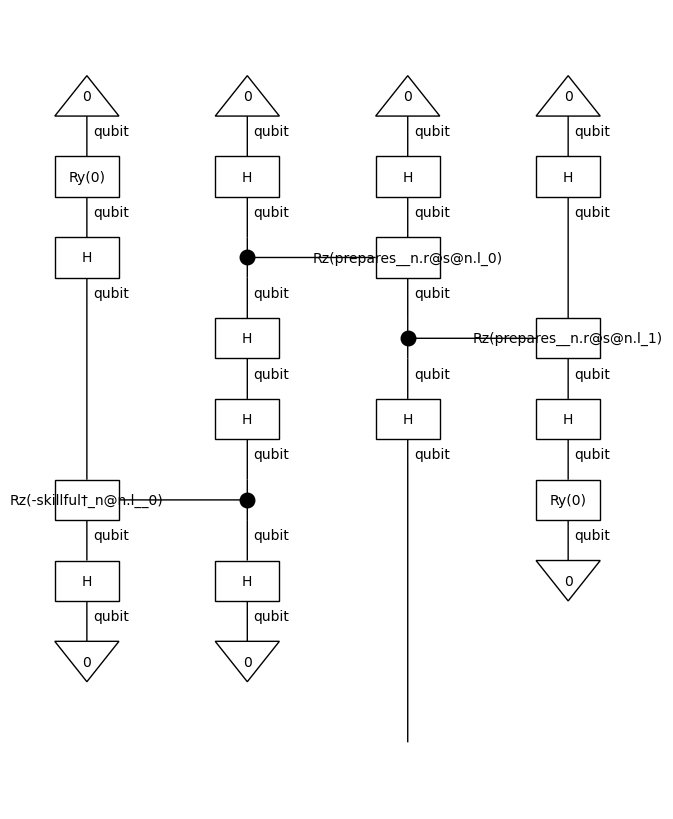

In [10]:
# create quantum circuits using the amplitude encoding ansatz

from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

# replace the naive way of encoding with the amplitude encoding Code developed in the file IQPAmplitudeEncoding.py 
from IQPAmplitudeEncode import * 
from IQPAmplitudeEncode_1QB import * 

# the corresponding function is IQPAmplitudeEncode2QB
# ansatz = IQPAmplitudeEncode2QB({AtomicType.NOUN: 2, AtomicType.SENTENCE: 1},
#                    n_layers=1, nounParams=np.array([1,2,3,4, 1,2,3,4,]), parameterDict=parameterDict, n_single_qubit_params=3)
ansatz = IQPAmplitudeEncode({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, nounParams=np.array([1,2,3,4, 1,2,3,4,]), n_single_qubit_params=3)


# from IQPAmplitudeEnc yers=1, nounParams=np.array([1,2,3,4, 1,2,3,4,]), n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
val_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(6, 8))

First model: Pennylane 

In [11]:
from lambeq import PennyLaneModel

all_circuits = train_circuits + val_circuits + test_circuits

# if no backend_config is provided, the default is used, which is the same as below
backend_config = {'backend': 'default.qubit'}  # this is the default PennyLane simulator
modelPennylane = PennyLaneModel.from_diagrams(all_circuits,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
modelPennylane.initialise_weights()



In [12]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)
                          
val_dataset = Dataset(val_circuits, val_labels)

In [13]:
def accPL(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)

In [14]:
from lambeq import PytorchTrainer
import torch

trainerPennylane = PytorchTrainer(
    model=modelPennylane,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': accPL},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

In [15]:
# trainer.fit(train_dataset, val_dataset)#, early_stopping_interval=10)

trainerPennylane.fit(train_dataset, val_dataset)

Epoch 1:    train/loss: 0.4057   valid/loss: 0.3577   train/acc: 0.6000   valid/acc: 0.5667
Epoch 2:    train/loss: 0.1681   valid/loss: 0.3304   train/acc: 0.6714   valid/acc: 0.5333
Epoch 3:    train/loss: 0.0937   valid/loss: 0.3202   train/acc: 0.6714   valid/acc: 0.5333
Epoch 4:    train/loss: 0.1643   valid/loss: 0.3020   train/acc: 0.6714   valid/acc: 0.5333
Epoch 5:    train/loss: 0.1613   valid/loss: 0.2870   train/acc: 0.7000   valid/acc: 0.5333
Epoch 6:    train/loss: 0.3469   valid/loss: 0.2711   train/acc: 0.7143   valid/acc: 0.5667
Epoch 7:    train/loss: 0.1394   valid/loss: 0.2400   train/acc: 0.7429   valid/acc: 0.6667
Epoch 8:    train/loss: 0.1401   valid/loss: 0.2301   train/acc: 0.8000   valid/acc: 0.6000
Epoch 9:    train/loss: 0.1222   valid/loss: 0.2201   train/acc: 0.8000   valid/acc: 0.6000
Epoch 10:   train/loss: 0.0921   valid/loss: 0.2012   train/acc: 0.7857   valid/acc: 0.7000
Epoch 11:   train/loss: 0.1880   valid/loss: 0.1841   train/acc: 0.7857   valid/

Second model: Numpy 

In [16]:
# Do the same thing, but now using the NUMPY model! 

from lambeq import NumpyModel

modelNumpy = NumpyModel.from_diagrams(all_circuits, use_jit=False)


from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()

accNP = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": accNP}


# NUMPY model uses QuantumTrainer class 

from lambeq import QuantumTrainer, SPSAOptimizer

trainerNumpy = QuantumTrainer(
    modelNumpy,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)




In [17]:
# train the numpy model 

trainerNumpy.fit(train_dataset, val_dataset)

Epoch 1:    train/loss: 0.5466   valid/loss: 0.8182   train/acc: 0.6000   valid/acc: 0.6000
Epoch 2:    train/loss: 0.6298   valid/loss: 0.7207   train/acc: 0.6714   valid/acc: 0.7333
Epoch 3:    train/loss: 0.5235   valid/loss: 0.7034   train/acc: 0.6000   valid/acc: 0.7000
Epoch 4:    train/loss: 0.6645   valid/loss: 0.6977   train/acc: 0.6857   valid/acc: 0.7000
Epoch 5:    train/loss: 0.4694   valid/loss: 0.7027   train/acc: 0.7000   valid/acc: 0.7333
Epoch 6:    train/loss: 0.2532   valid/loss: 0.6626   train/acc: 0.7000   valid/acc: 0.7333
Epoch 7:    train/loss: 0.5258   valid/loss: 0.6313   train/acc: 0.7429   valid/acc: 0.7333
Epoch 8:    train/loss: 0.4599   valid/loss: 0.6405   train/acc: 0.7429   valid/acc: 0.7333
Epoch 9:    train/loss: 0.5477   valid/loss: 0.6256   train/acc: 0.7571   valid/acc: 0.7333
Epoch 10:   train/loss: 0.3885   valid/loss: 0.6167   train/acc: 0.7143   valid/acc: 0.7333
Epoch 11:   train/loss: 0.3856   valid/loss: 0.6072   train/acc: 0.7000   valid/

Third model: Tket 

In [18]:
'''
Same thing, but for Tket model 
'''

from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

modelTK = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bceTK = BinaryCrossEntropyLoss()

accTK = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metricsTK = {"acc": accTK}

from lambeq import QuantumTrainer, SPSAOptimizer

trainerTK = QuantumTrainer(
    modelTK,
    loss_function=bceTK,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metricsTK,
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)


trainerTK.fit(train_dataset, val_dataset)#, early_stopping_interval=10)

Epoch 1:    train/loss: 0.5225   valid/loss: 0.6657   train/acc: 0.6000   valid/acc: 0.5667


Epoch 2:    train/loss: 0.7012   valid/loss: 0.6533   train/acc: 0.5786   valid/acc: 0.8000
Epoch 3:    train/loss: 0.6087   valid/loss: 0.6048   train/acc: 0.6857   valid/acc: 0.8167
Epoch 4:    train/loss: 0.6522   valid/loss: 0.5290   train/acc: 0.7143   valid/acc: 0.8667
Epoch 5:    train/loss: 0.4842   valid/loss: 0.5064   train/acc: 0.7643   valid/acc: 0.8833
Epoch 6:    train/loss: 0.6073   valid/loss: 0.4406   train/acc: 0.7357   valid/acc: 0.8333
Epoch 7:    train/loss: 0.8163   valid/loss: 0.6754   train/acc: 0.5714   valid/acc: 0.6667
Epoch 8:    train/loss: 0.7891   valid/loss: 0.5903   train/acc: 0.5714   valid/acc: 0.7333
Epoch 9:    train/loss: 0.3734   valid/loss: 0.6225   train/acc: 0.6786   valid/acc: 0.6667
Epoch 10:   train/loss: 0.4959   valid/loss: 0.6183   train/acc: 0.6143   valid/acc: 0.6667
Epoch 11:   train/loss: 0.6568   valid/loss: 0.5922   train/acc: 0.6857   valid/acc: 0.7333
Epoch 12:   train/loss: 0.5634   valid/loss: 0.5776   train/acc: 0.6214   valid/

In [19]:
'''
Before we look at the results of the training, let us understand what exactly these circuits are that we trained above. 

We start by extracting the parameters for the symbols learned by Coecke et al. 


'''

# The symbols are the names of the respective parameters for the respective words
smbls = modelNumpy.symbols

# And the weights are their respective values 
weights = modelNumpy.weights

# create a simple dictionary for parameters and weights 
parameterDict = {}
for i in range(len(smbls)):
    parameterDict[str(smbls[i])] = weights[i].item()


import pickle

# with open('../weights/weightsDict_NP_2QB_AEICA_500_gijs.pkl', 'wb') as fp:
#     pickle.dump(parameterDict, fp)



Final test accuracy: 0.0
Validation accuracy: 0.7833333333333333


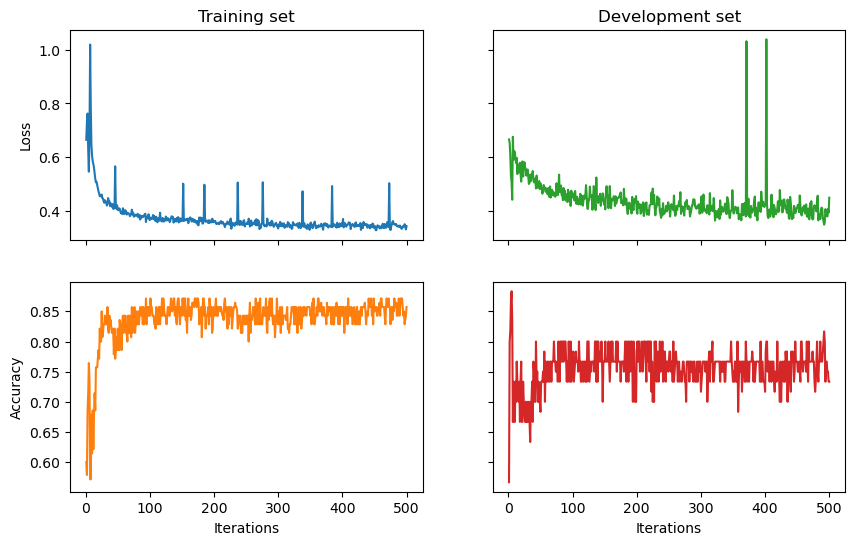

In [20]:
'''
Performance of the model!! 
'''


import matplotlib.pyplot as plt

trainer = trainerTK
model = modelTK
acc = accTK
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circuits)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(acc(pred, labels)))

# print test accuracy - tket
modelTK.load(trainerTK.log_dir + '/best_model.lt')
val_acc = accTK(modelTK(test_circuits), test_labels)
print('Validation accuracy:', val_acc.item())

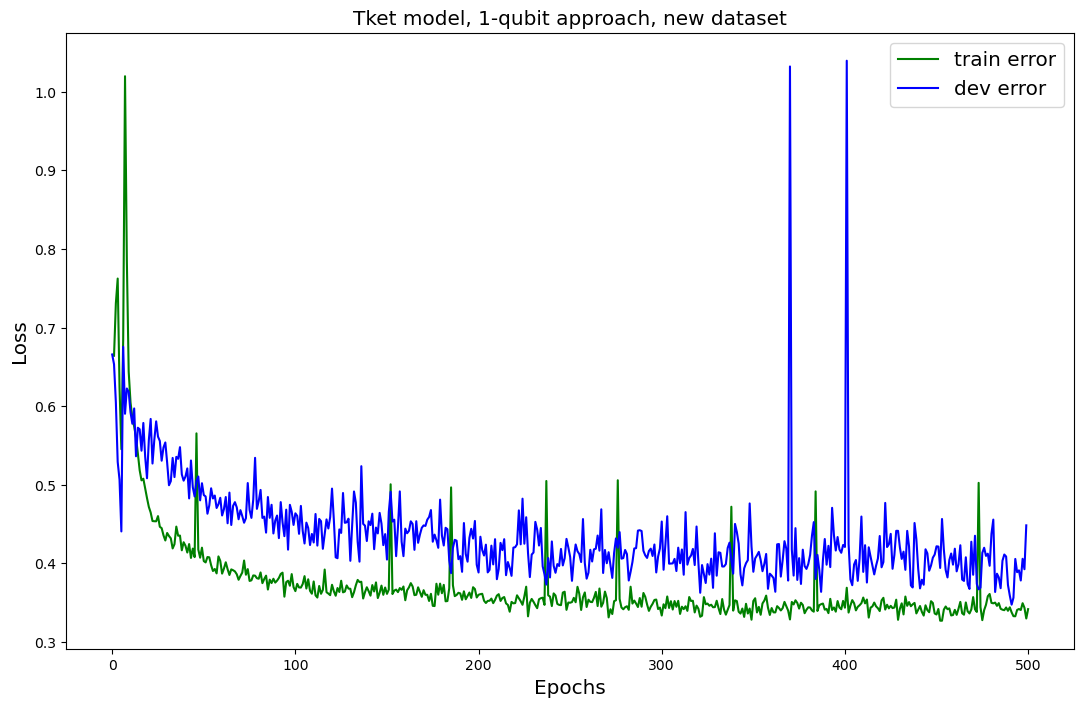

In [37]:
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots(figsize=(13, 8))

# ax1.plot(range_, trainer.train_epoch_costs, '-k', markersize=4, label='cost')
ax1.plot(range_, trainer.train_epoch_costs, '-g', markersize=4, label='train error')
ax1.plot(range(len(trainer.val_costs)), trainer.val_costs, '-b', markersize=4, label='dev error')
ax1.set_ylabel(r"Loss", fontsize='x-large')
ax1.set_xlabel(r"Epochs", fontsize='x-large')
# ax1.legend(loc='upper center', fontsize='x-large')

# ax2 = ax1.twinx()
# ax2.set_ylabel(r"Error in \%", fontsize='x-large')
# ax2.plot(range_, trainer.train_epoch_costs, '-g', markersize=4, label='train error')
# ax2.plot(range(len(trainer.val_costs)), trainer.val_costs, '-b', markersize=4, label='dev error')
# ax2.plot(range(len(trainer.train_costs)), trainer.train_costs, '-r', markersize=4, label='test error')
ax1.legend(loc='upper right', fontsize='x-large')


plt.title('Tket model, 1-qubit approach, new dataset', fontsize='x-large')
plt.savefig('MC_task_ECS_Results.png', dpi=300, facecolor='white')  
plt.show()


In [22]:
# save the models parameters to pkl files 



# # numpy 
# model = modelNumpy
# trainer = trainerNumpy
# filename = '../modelParameters/NumpyModel_AEICA_2QB_500'
# acc = accNP
# model.load(trainer.log_dir + '/best_model.lt')
# val_acc = acc(model(test_circuits), test_labels)

# dump_data = {
#     'train_epoch_cost': trainer.train_epoch_costs,
#     'train_eval_results': trainer.train_eval_results['acc'],
#     'val_costs': trainer.val_costs, 
#     'val_eval_results': trainer.val_eval_results['acc'],
#     'test_acc': val_acc.item()
# }
# with open(filename+'.pkl', 'wb') as file_handle:
#     pickle.dump(dump_data, file_handle)




# # tket
# model = modelTK
# trainer = trainerTK
# filename = '../modelParameters/TKetModel_AEICA_2QB_500'
# acc = accTK
# model.load(trainer.log_dir + '/best_model.lt')
# val_acc = acc(model(test_circuits), test_labels)

# dump_data = {
#     'train_epoch_cost': trainer.train_epoch_costs,
#     'train_eval_results': trainer.train_eval_results['acc'],
#     'val_costs': trainer.val_costs, 
#     'val_eval_results': trainer.val_eval_results['acc'],
#     'test_acc': val_acc.item()
# }
# with open(filename+'.pkl', 'wb') as file_handle:
#     pickle.dump(dump_data, file_handle)







# # pennylane 
# model = modelPennylane
# trainer = trainerPennylane
# acc = accPL
# filename = '../modelParameters/PennylaneModel_AEICA_2QB_500'
# pred = model(test_circuits)
# labels = torch.tensor(test_labels)

# dump_data = {
#     'train_epoch_cost': trainer.train_epoch_costs,
#     'train_eval_results': trainer.train_eval_results['acc'],
#     'val_costs': trainer.val_costs, 
#     'val_eval_results': trainer.val_eval_results['acc'],
#     'test_acc': acc(pred, labels)
# }
# with open(filename+'.pkl', 'wb') as file_handle:
#     pickle.dump(dump_data, file_handle)